In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score

import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

plt.rcParams['axes.unicode_minus'] = False # 顯示負號

In [10]:
tfidf_train_data = pd.read_csv('../Data/TrainingData/tfidf_train.csv')
tfidf_val_data = pd.read_csv('../Data/ValidateData/tfidf_val.csv')
word2vec_train_data = pd.read_csv('../Data/TrainingData/word2vec_train.csv')
word2vec_val_data = pd.read_csv('../Data/ValidateData/word2vec_val.csv')
bert_train_data = pd.read_csv('../Data/TrainingData/bert_train.csv')
bert_val_data = pd.read_csv('../Data/ValidateData/bert_val.csv')

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
class GRUModel(nn.Module):
    def __init__(self, input_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, 256, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), 256).to(device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

In [19]:
def train_gru_model(df, model_path, scaler_path):
    data = df.copy()
    y = data.pop('source')

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data.values)
    joblib.dump(scaler, scaler_path)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).view(-1, 1, X_train.shape[1]).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).view(-1, 1, X_test.shape[1]).to(device)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)

    input_size = X_train_tensor.shape[2]
    model = GRUModel(input_size).to(device)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    model.eval()
    with torch.no_grad():
        y_pred_train = model(X_train_tensor).cpu().numpy()
        y_pred_test = model(X_test_tensor).cpu().numpy()

        y_pred_train = (y_pred_train > 0.5).astype(int)
        y_pred_test = (y_pred_test > 0.5).astype(int)

        y_train_numpy = y_train_tensor.cpu().numpy()
        y_test_numpy = y_test_tensor.cpu().numpy()

        cm_train = confusion_matrix(y_train_numpy, y_pred_train)
        cm_test = confusion_matrix(y_test_numpy, y_pred_test)

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    sns.heatmap(cm_train, annot=True, fmt='d', ax=ax[0], cmap='Blues')
    ax[0].set_title('Train Confusion Matrix')
    ax[0].set_xlabel('Predicted')
    ax[0].set_ylabel('Actual')

    sns.heatmap(cm_test, annot=True, fmt='d', ax=ax[1], cmap='Blues')
    ax[1].set_title('Test Confusion Matrix')
    ax[1].set_xlabel('Predicted')
    ax[1].set_ylabel('Actual')

    plt.show()

    torch.save(model, model_path)
    return model, scaler

In [20]:
def evaluate_on_new_data(model, scaler, new_data):
    data = new_data.copy()
    y_new = data.pop('source')
    X_new_scaled = scaler.transform(data.values)

    X_new_tensor = torch.tensor(X_new_scaled, dtype=torch.float32).view(-1, 1, X_new_scaled.shape[1]).to(device)
    y_new_tensor = torch.tensor(y_new.values, dtype=torch.float32).view(-1, 1).to(device)

    model.eval()
    with torch.no_grad():
        y_pred_new = model(X_new_tensor).cpu().numpy()
        y_pred_new = (y_pred_new > 0.5).astype(int)
        y_new_numpy = y_new_tensor.cpu().numpy()

        new_f2 = fbeta_score(y_new_numpy, y_pred_new, beta=2)
        cm_new = confusion_matrix(y_new_numpy, y_pred_new)

    print(f'New Data F2 Score: {new_f2:.4f}')

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_new, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix on New Data')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

Epoch [10/100], Loss: 0.0167
Epoch [20/100], Loss: 0.0042
Epoch [30/100], Loss: 0.0022
Epoch [40/100], Loss: 0.0015
Epoch [50/100], Loss: 0.0012
Epoch [60/100], Loss: 0.0010
Epoch [70/100], Loss: 0.0009
Epoch [80/100], Loss: 0.0008
Epoch [90/100], Loss: 0.0007
Epoch [100/100], Loss: 0.0006


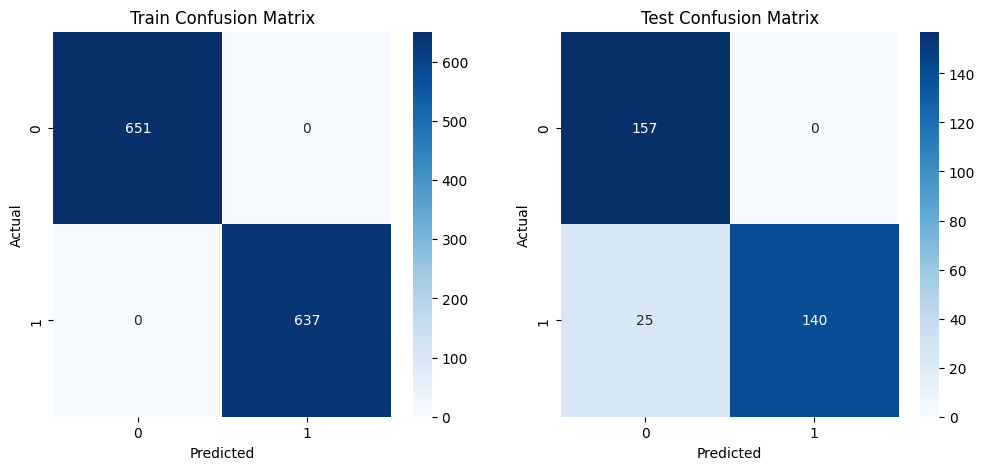

New Data F2 Score: 0.9032


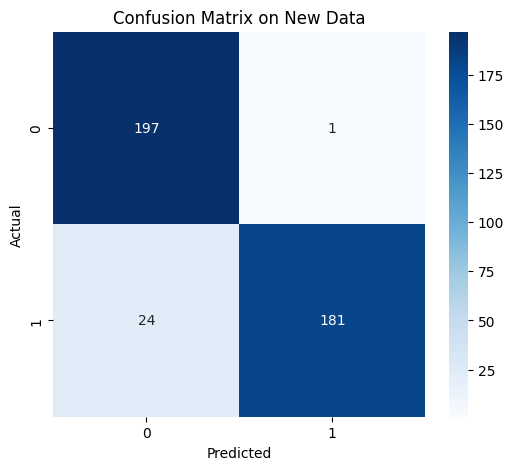

In [21]:
model, scaler = train_gru_model(tfidf_train_data, '../Data/Model/tfidf_gru_model.pth', '../Data/Model/tfidf_scaler.pkl')
evaluate_on_new_data(model, scaler, tfidf_val_data)

Epoch [10/100], Loss: 0.4041
Epoch [20/100], Loss: 0.2336
Epoch [30/100], Loss: 0.1472
Epoch [40/100], Loss: 0.1042
Epoch [50/100], Loss: 0.0815
Epoch [60/100], Loss: 0.0676
Epoch [70/100], Loss: 0.0579
Epoch [80/100], Loss: 0.0503
Epoch [90/100], Loss: 0.0441
Epoch [100/100], Loss: 0.0389


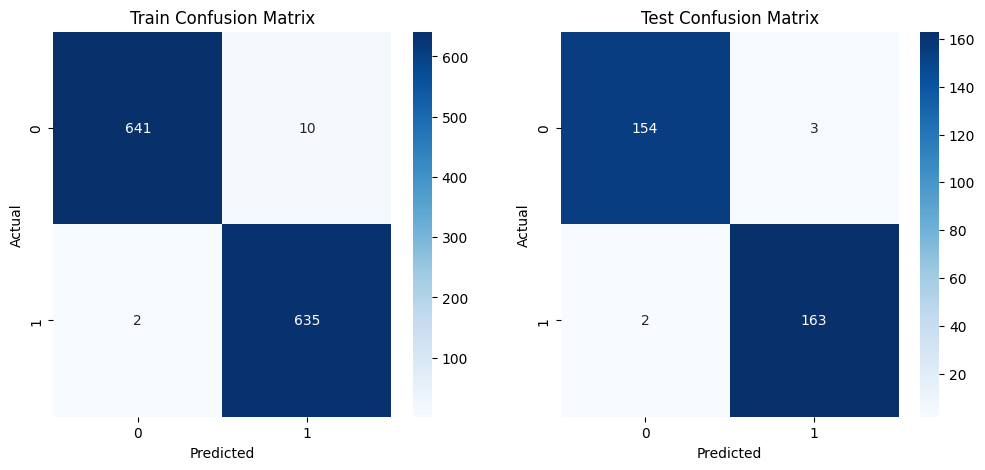

New Data F2 Score: 0.9726


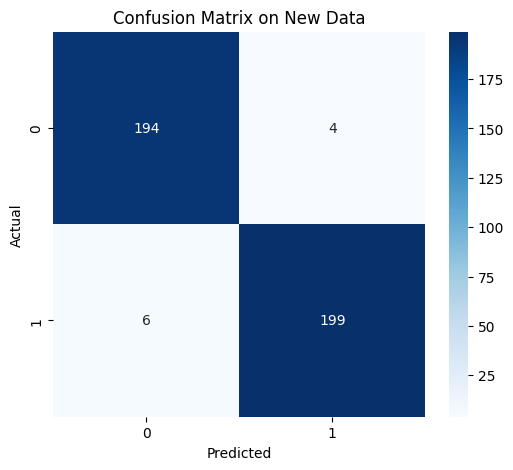

In [22]:
model, scaler = train_gru_model(word2vec_train_data, '../Data/Model/word2vec_gru_model.pth', '../Data/Model/word2vec_scaler.pkl')
evaluate_on_new_data(model, scaler, word2vec_val_data)

Epoch [10/100], Loss: 0.0492
Epoch [20/100], Loss: 0.0114
Epoch [30/100], Loss: 0.0050
Epoch [40/100], Loss: 0.0031
Epoch [50/100], Loss: 0.0023
Epoch [60/100], Loss: 0.0019
Epoch [70/100], Loss: 0.0016
Epoch [80/100], Loss: 0.0014
Epoch [90/100], Loss: 0.0012
Epoch [100/100], Loss: 0.0011


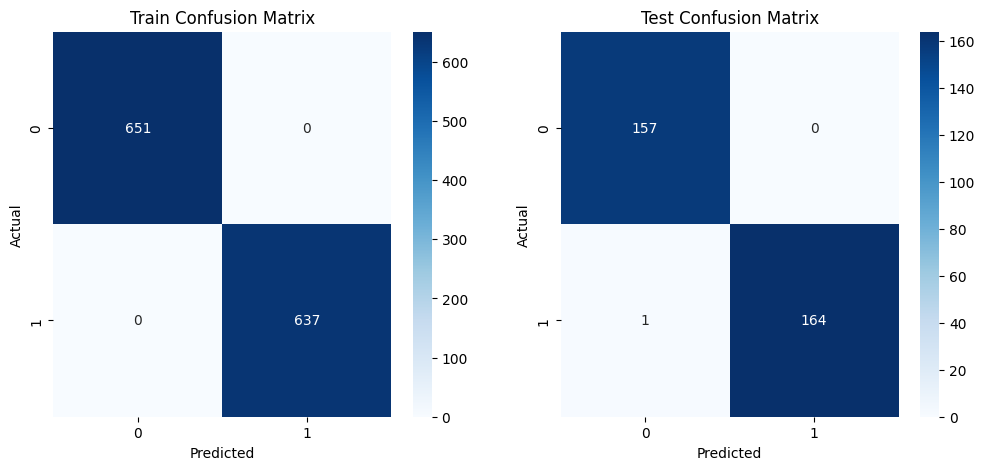

New Data F2 Score: 1.0000


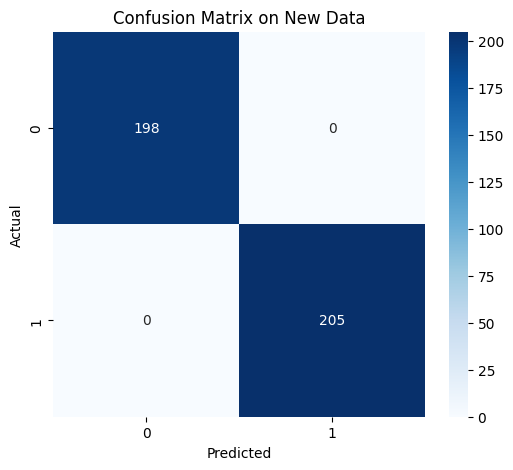

In [23]:
model, scaler = train_gru_model(bert_train_data, '../Data/Model/bert_gru_model.pth', '../Data/Model/bert_scaler.pkl')
evaluate_on_new_data(model, scaler, bert_val_data)